In [1]:
import numpy as np
from pecanpy import pecanpy # pip install pecanpy

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def color_labels(n, m, k):
    N = n * m + (k - 1) * (n - 1) # size of graph
    label_ary = np.zeros(N, dtype=int)
    
    for i in range(n - 1): # label bars
        end_idx = (i + 1) * (m + k -1) + 1
        start_idx = end_idx - (k + 1)
        for j in range(np.ceil((k + 1) / 2).astype(int)):
            label_ary[start_idx+j:end_idx-j] += 1

    return label_ary

def generate_barbell(noise):
    n = 2  # number of bell
    m = 20  # size of bell
    k = 2  # length of bar

    N = n * m + (k - 1) * (n - 1) # size of graph
    M = np.zeros((N, N))
    
    # construct bells
    for i in range(n):
        start_idx = i * (m + k -1)
        end_idx = start_idx + m
        M[start_idx:end_idx,start_idx:end_idx] = 1
        
    # add bars
    P = np.eye(k + 1, k=1) + np.eye(k + 1, k=-1)
    for i in range(n - 1):
        end_idx = (i + 1) * (m + k -1) + 1
        start_idx = end_idx - (k + 1)
        M[start_idx:end_idx,start_idx:end_idx] += P
    
    M[M==0] += noise
        
    return M

def embed(M, q, extend):
    g = pecanpy.DenseOTF(1, q=q, workers=4, verbose=False, extend=extend)
    g.data, g.nonzero = M, M != 0
    g.IDlst = [str(i) for i in range(M.shape[0])]
    g.IDmap = {j: i for i, j in enumerate(g.IDlst)}

    walks = g.simulate_walks(num_walks=10, walk_length=80)
    mdl = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=0, 
                          sg=1, workers=4, epochs=5)

    idx_ary = np.array(mdl.wv.index_to_key, dtype=int).argsort()
    emd = mdl.wv.vectors[idx_ary]
    
    return emd

def plot_embeddings(M, extend=False):
    fig, axes = plt.subplots(1, 3, figsize=(9,3.2))
    for q, ax in zip((1, 100, 0.01), axes):
        # generate embeddings
        emd = embed(M, q, extend)
        
        # PCA 
        X = emd - emd.mean(axis=0)
        u, s, v = np.linalg.svd(X)
        X = u[:,:2] * s[:2]

        # plot embeddings
        for i in range(label_ary.max()+1):
            idx_ary = np.where(label_ary==i)[0]
            ax.scatter(X[idx_ary,0], X[idx_ary,1], color=color_list[i], marker=maker_list[i])

        ax.set_title(f"q = {q}")
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        
    plt.tight_layout()
    plt.show()


In [3]:
color_list = ['magenta', 'limegreen', 'darkgrey']
maker_list = ['o', 's', '^']
label_ary = color_labels(2, 20, 2)

M = generate_barbell(0)
M_noisy = generate_barbell(0.1)

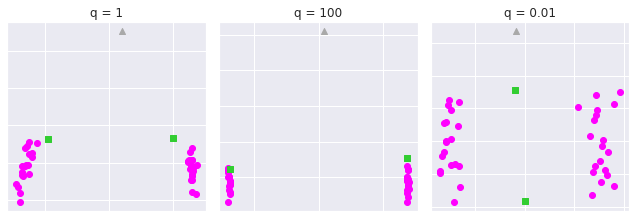

In [4]:
# node2vec on clean Barbell graph
plot_embeddings(M)

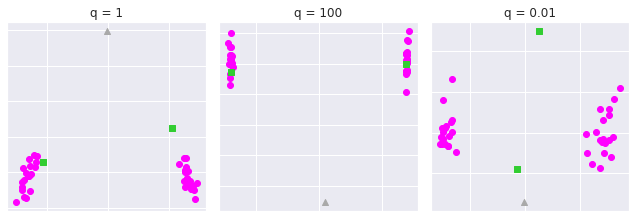

In [5]:
# node2vec+ on clean Barbell graph
plot_embeddings(M, extend=True)

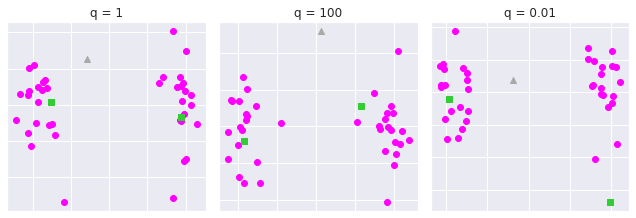

In [6]:
# node2vec on noisy Barbell graph
plot_embeddings(M_noisy)

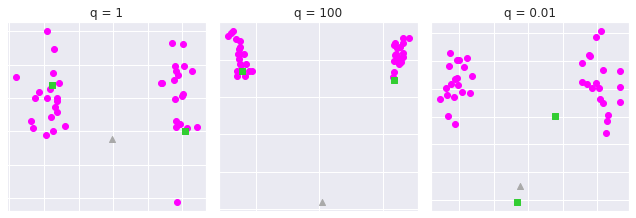

In [7]:
# node2vec+ on noisy Barbell graph
plot_embeddings(M_noisy, extend=True)